This tutorial introduces __SimSoM__: A Simulator of Social Media. 
In this notebook, we provide a minimal example for running a simulation and take a look at the results. 

# What is SimSoM?

We model information diffusion in a social media platform such as Twitter/X, Instagram, or Mastodon. The information system is a directed network with nodes representing accounts and links representing follower relations. Similar to real-world platforms, content circulates through messages that appear in news feeds. Agents can post new messages or reshare messages from their feeds, generated by their friends, i.e., the accounts they follow.

Messages represent information that could take the form of text, links, hashtags, images, or other media. An agent can introduce a new message into the system 

or, alternatively, select a message from their news feed to reshare. 
Messages created and reshared by an agent then appear on the news feeds of their followers.

[*Quantifying the Vulnerabilities of the Online Public Square to Adversarial Manipulation Tactics*](https://arxiv.org/abs/1907.06130)

![image](figures/1.infosys.png)

# How to install SimSoM
Code to run the simulator & directions to install the package is documented at the [Github repository SimSoM](https://github.com/osome-iu/SimSoM)

# Run simulations 
## Import packages 

In [3]:
try:
    from simsom import SimSom
    import simsom.graphutils as simsomgraph
    import simsom.utils as simsomutils
except ModuleNotFoundError:
    print(
        "Unable to import simsom package. \n"
        "Change to root directory of this project and run `pip install -e ./libs/`"
    )

import json
import numpy as np
import os
from copy import deepcopy

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

There are 2 steps in running a simulation. 
First we create a network (including bot subnetwork) as the input to Simsom, where the simulation happens
- `graph_specs` specifies the parameters for the bot subnetwork ($\beta, \gamma$) and whether to use empirical network data. If "human_network" is None, the human subnetwork is created using a random walk growth model with default values (p=0.5, k_out=3)
- `simulation_specs` specifies the parameters for the simulation, such as $\sigma, \mu, \phi, \theta$

# Information diffusion

## Load existing network

In [9]:
DATA_PATH = "data"
network_fpath = os.path.join(DATA_PATH, "infosys.gml")
if not os.path.exists(network_fpath):
    print("Information network not found. Creating a new one..")
    net_specs = {
        # "human_network": os.path.join(DATA_PATH, "follower_network.gml"),
        "beta": 0,
        "gamma": 0,
        "verbose": True,
    }

    G = simsomgraph.init_net(**net_specs)
    G.write(network_fpath, format="gml")

## Configure & Run simulations

In [10]:
RESULT_DIR = "results_base"
if os.path.exists(RESULT_DIR) is False:
    os.mkdir(RESULT_DIR)
reshare_fpath = os.path.join(RESULT_DIR, "reshare.csv")
message_info_fpath = os.path.join(RESULT_DIR, "message_info.json.gz")

simulation_specs = {
    "verbose": False,
    "tracktimestep": True,
    "save_message_info": True,
    "output_cascades": True,
    "mu": 0.5,  # agents post half of the time, reshare half of the time
}

print("*** Start simulation ***")
print(f"Create SimSom instance..")
# Create a SimSom instance
follower_sys = SimSom(network_fpath, **simulation_specs)

# Run simulation
results = follower_sys.simulation(reshare_fpath=reshare_fpath)
quality = results["quality"]
print(f" - Simulation finished. Quality: {np.round(quality,3)}")

# Save verbose results (with simulation specs)
if simulation_specs["save_message_info"] is True:
    specs = deepcopy(simulation_specs)
    specs.update(results)
    simsomutils.write_json_compressed(message_info_fpath, specs)

# Save short results (with simulation specs)
simulation_specs.update({"quality": quality})
json.dump(simulation_specs, open(os.path.join(RESULT_DIR, "results.json"), "w"))

*** Start simulation ***
Create SimSom instance..
 - Simulation running on 7 threads
	 Created message using appeal exp alpha=5
 - Simulation finished. Quality: 0.812
Successfully wrote to results_base/message_info.json.gz


# Explore the results 

The short result, containing only simulation specs and quality across runs is stored in __results/results.json__. 
SimSom additionally keeps track of other information in a dictionary, stored in __'results/message_info_*.json.gz'__, such as:
- message popularity ('all_messages' key)
- human news feed ('all_feeds' key)
- quality across timesteps ('quality_timestep' key)
It also outputs reshare data (__reshare_*.csv__) in an edgelist format that can be used to reconstruct the cascade
Let's first check what's available

## Message metadata

In [4]:
verbose = simsomutils.read_json_compressed("results/message_info.json.gz")
verbose.keys()

dict_keys(['verbose', 'tracktimestep', 'save_message_info', 'output_cascades', 'mu', 'quality', 'diversity', 'discriminative_pow', 'quality_timestep', 'exposure_timestep', 'age_timestep', 'all_messages', 'reshared_messages', 'feeds_message_ids', 'feeds_shares', 'feeds_ages'])

Let's take a look at message popularity, where each row is information about a message.

In [5]:
import pandas as pd

messages = pd.DataFrame.from_records(verbose["all_messages"])
messages.head()

,id,is_by_bot,phi,appeal_exp,quality,appeal,agent_id,human_shares,bot_shares,spread_via_agents,seen_by_agents,seen_by_agent_timestep,qual_th,share_th
0,2,0.0,0,5,0.441831,0.164919,733,3,0,"[733, 946, 848]","[793, 946, 848, 793, 848, 946, 793, 946, 848, ...","[2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...",1804,30607
1,1,0.0,0,5,0.909439,0.005179,356,1,0,[356],"[892, 657, 448, 447, 432, 643, 939, 939, 432, ...","[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, ...",21480,17324
2,3,0.0,0,5,0.850247,0.024731,446,1,0,[446],[],[],15848,12777
3,4,0.0,0,5,0.893481,0.524563,809,1,0,[809],"[855, 855, 855, 855, 855, 855, 855]","[2, 3, 4, 5, 6, 7, 8]",19783,15956
4,5,0.0,0,5,0.899400,0.195765,699,1,0,[699],[],[],20405,16463


## Quality vs timestep
We can also plot the quality of the network over time until convergence.

Text(0.5, 1.0, 'Quality vs timestep')

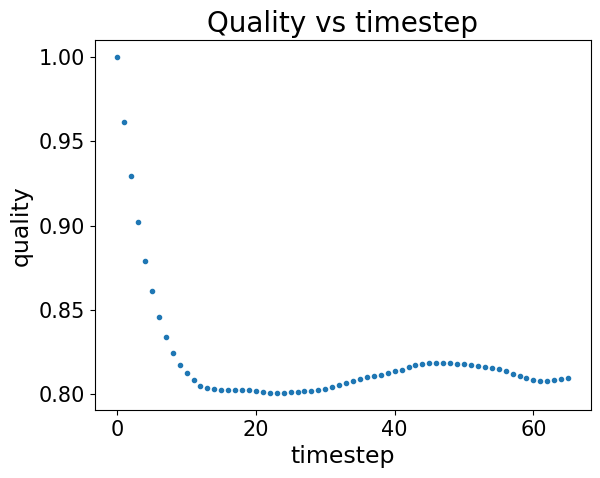

In [15]:
import matplotlib.pyplot as plt

# Styling
plt.style.use("viz/stylesheet.mplstyle")

timesteps = len(verbose["quality_timestep"])
plt.scatter(range(timesteps), verbose["quality_timestep"], s=9)
plt.xlabel("timestep")
plt.ylabel("quality")
plt.title("Quality vs timestep")

## Reshare network 

One can also create reshare and exposure network visualization using the reshare information saved in `reshare.csv`. 

An example: 

![image](figures/reshare.png)

Example of how to derive the the `.gml` file for this network is also provided.

# Manipulation tactics 

## Create & save a synthetic network

In [22]:
DATA_PATH = "data"
network_fpath = os.path.join(DATA_PATH, "infosys_with_bot.gml")
if not os.path.exists(network_fpath):
    print("Information network not found. Creating a new one..")
    net_specs = {
        "targeting_criterion": None,
        "human_network": os.path.join(DATA_PATH, "follower_network.gml"),
        "beta": 0.05,  # 50 bot
        "gamma": 0.01,  # each has 10 followers
        "verbose": True,
    }

    G = simsomgraph.init_net(**net_specs)

    G.write(network_fpath, format="gml")

## Configure & Run simulations

In [23]:
RESULT_DIR = "results_manipulation"
if os.path.exists(RESULT_DIR) is False:
    os.mkdir(RESULT_DIR)
reshare_fpath = os.path.join(RESULT_DIR, "reshare.csv")
message_info_fpath = os.path.join(RESULT_DIR, "message_info.json.gz")

simulation_specs = {
    "verbose": False,
    "tracktimestep": True,
    "save_message_info": True,
    "output_cascades": True,
    "mu": 0.5,  # agents post half of the time, reshare half of the time
    "theta": 5,
}

print("*** Start simulation ***")
print(f"Create SimSom instance..")
# Create a SimSom instance
follower_sys = SimSom(network_fpath, **simulation_specs)

# Run simulation
results = follower_sys.simulation(reshare_fpath=reshare_fpath)
quality = results["quality"]
print(f" - Simulation finished. Quality: {np.round(quality,3)}")

# Save verbose results (with simulation specs)
if simulation_specs["save_message_info"] is True:
    specs = deepcopy(simulation_specs)
    specs.update(results)
    simsomutils.write_json_compressed(message_info_fpath, specs)

# Save short results (with simulation specs)
simulation_specs.update({"quality": quality})
json.dump(simulation_specs, open(os.path.join(RESULT_DIR, "results.json"), "w"))

*** Start simulation ***
Create SimSom instance..
 - Simulation running on 7 threads
	 Created message using appeal exp alpha=5
 - Simulation finished. Quality: 0.782
Successfully wrote to results_manipulation/message_info.json.gz


In [16]:
RESULT_DIR = "results_manipulation"

Text(0.5, 1.0, 'System with bot manipulation')

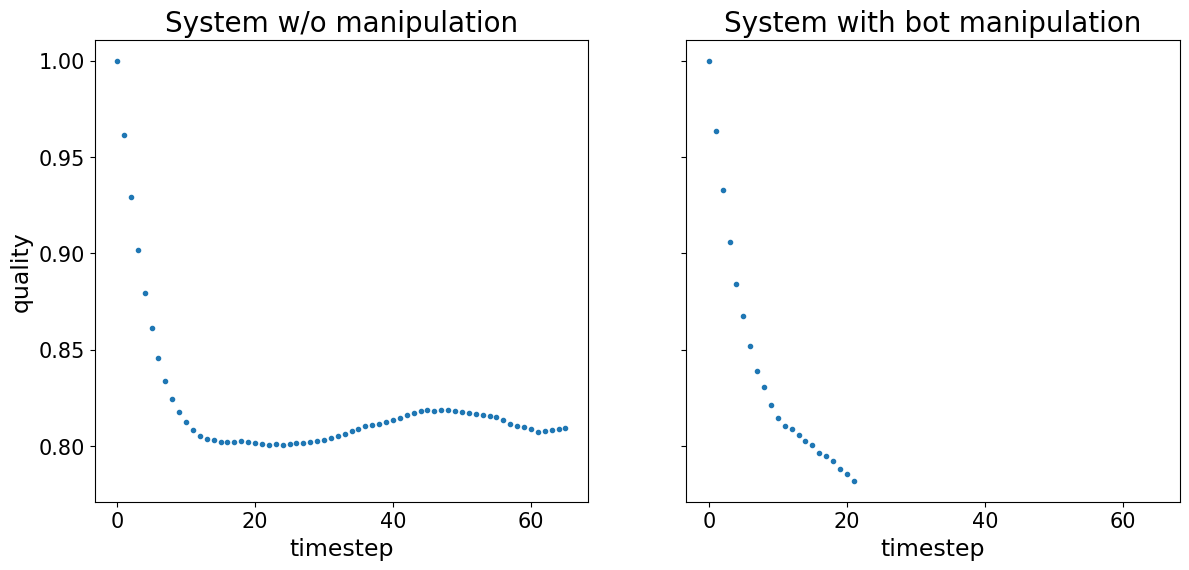

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

verbose_wbot = simsomutils.read_json_compressed(f"{RESULT_DIR}/message_info.json.gz")
messages_wbot = pd.DataFrame.from_records(verbose_wbot["all_messages"])

## Quality vs timestep

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

timesteps_wbot = len(verbose_wbot["quality_timestep"])
axs[1].scatter(range(timesteps_wbot), verbose_wbot["quality_timestep"], s=9)

axs[0].scatter(range(timesteps), verbose["quality_timestep"], s=9)

axs[0].set_xlabel("timestep")
axs[1].set_xlabel("timestep")
axs[0].set_ylabel("quality")
axs[0].set_title("System w/o manipulation")
axs[1].set_title("System with bot manipulation")

## Exposure to bad actor messages vs timestep
We can also observe how exposure to bad actor content varies over time
Exposure is calculated using [Facebook's definition](https://about.fb.com/news/2022/11/integrity-and-transparency-reports-q3-2022/) for the prevalence of problematic content: exposure = no. views for that content / estimated no. total content view

Text(0.5, 1.0, 'Exposure to bad actor vs timestep')

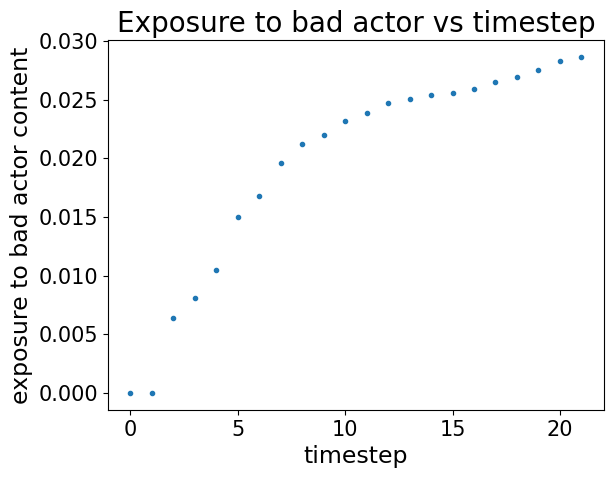

In [18]:
import matplotlib.pyplot as plt

plt.scatter(range(timesteps_wbot), verbose_wbot["exposure_timestep"], s=9)
plt.xlabel("timestep")
plt.ylabel("exposure to bad actor content")
plt.title("Exposure to bad actor vs timestep")

This concludes our introductory tutorial to SimSom. Read our paper to learn more about possible analysis and our findings on an empirical network using this Simulator, and get in touch with us at our GitHub repo if you have any questions/issues!

## Where to go next with SimSoM? 
- Examine the impacts of moderation strategy on harmful/illegal content 

![image](figures/poster.jpg)

- Examine the impacts of recommendation systems on information diffusion 
- Examine different user behaviors 

**Contributions/ suggestions welcomed. Please reach out to me!! baotruon@iu.edu**